In [1]:
import pandas as pd
df_ml = pd.read_csv("../data/processed/ML_Chile_2022-12-27.csv")
df_ml.dropna(subset=["tweet_text"], inplace=True)
# df_ml = df_ml[df_ml["sentiment"] != "others"]
df_ml["longitud_text"] = df_ml["tweet_text"].apply(len)
df_ml = df_ml[df_ml["longitud_text"] > 84.0]
df_ml.shape

(58, 9)

In [2]:
def df_to_list(df):
    texts = df["tweet_text"]
    data = []
    for text in texts:
        data.append(text)
    return data

In [3]:
import numpy as np
import torch
from transformers import BertModel, BertTokenizer
tokenizer_español = BertTokenizer.from_pretrained("../pytorch/", do_lower_case=False)
model = BertModel.from_pretrained("../pytorch")

Some weights of the model checkpoint at ../pytorch were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
from src import Features
inputs = df_to_list(df_ml)
inputs = Features.bert_encoder(inputs, tokenizer_español)
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

In [5]:
max_poll = Features.max_polling(last_hidden_states)
mean_poll = Features.mean_polling(last_hidden_states)

In [6]:
data_ml = {
        "Beto+maxPolling+stdN": Features.std_normalization(max_poll),
        "Beto+maxPolling+zScore": Features.z_score_normalization(max_poll),
        "Beto+maxPolling+minMax": Features.min_max_normalization(max_poll),
        "Beto+meanPolling+stdN": Features.std_normalization(mean_poll),
        "Beto+meanPolling+zScore": Features.z_score_normalization(mean_poll),
        "Beto+meanPolling+minMax": Features.min_max_normalization(mean_poll),
    }

In [7]:
def find_indexs(list, value):
    list_aux = list.copy()
    output = []
    while True:
        try:
            index = list_aux.index(value)
            output.append(index)
            list_aux[index] = None
        except ValueError:
            break
    return output

# agrupamiento

In [8]:
import sys

valor_minimo = sys.float_info.min
print(valor_minimo)

2.2250738585072014e-308


# k-means

In [9]:
# k-means
from sklearn.cluster import KMeans
from sklearn import metrics
agrupamiento = {}
metricas = {}
for K in range(2, 8):
    si = []
    vp = []
    for key, value in data_ml.items():
        if key not in metricas:
            metricas[key] = {
                "silhouettes_by_k_centroids": [],
                "VP_by_k_centroids": [],
            }
        # value shape: (77, 768)
        value = np.array(value)
        kmeans = KMeans(
            n_clusters=K,
            init="random",
            max_iter=10000,
            random_state=42,
            n_init=42,
        )
        cluster_labels = kmeans.fit_predict(value)
        centers = kmeans.cluster_centers_
        agrupamiento[key] = list(cluster_labels)
        variances = []
        for k in range(K):
            variance = Features.cluster_variance(value, cluster_labels, centers, k)
            variances.append(variance)
        avg_variance = sum(variances)/len(variances)
        vp.append(avg_variance)
        si.append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["silhouettes_by_k_centroids"].append(metrics.silhouette_score(
            value, kmeans.labels_, metric="sqeuclidean"))
        metricas[key]["VP_by_k_centroids"].append(avg_variance)

metricas

{'Beto+maxPolling+stdN': {'silhouettes_by_k_centroids': [0.19972901748900737,
   0.12397367197720088,
   0.11800392096291797,
   0.08288860273262687,
   0.08138186811445941,
   0.04377734562774152],
  'VP_by_k_centroids': [1.044790957315339e-06,
   1.5603426877463898e-06,
   1.084454012262186e-06,
   5.32661618827238e-07,
   4.250676465549532e-07,
   9.730672054565908e-07]},
 'Beto+maxPolling+zScore': {'silhouettes_by_k_centroids': [0.06924791040975381,
   0.06924548007386738,
   0.037584511491742724,
   0.042764566001881464,
   0.02963135145991415,
   0.027585865699389315],
  'VP_by_k_centroids': [0.7854479602742491,
   0.6915702700206582,
   0.650107909551113,
   1.009140029119132,
   0.8745351918888513,
   0.8486889375634649]},
 'Beto+maxPolling+minMax': {'silhouettes_by_k_centroids': [0.6280998831769588,
   0.5615306532281283,
   0.5343077965526394,
   0.42652314599055263,
   0.33580962487585303,
   0.25036933595561023],
  'VP_by_k_centroids': [0.09504864921767642,
   0.04253300891

In [10]:
op = {}
print(" & Número de grupos & Medida Silhouette & Medida VP")
for metricas_key in metricas.keys():
    ops = []
    opv = []
    sI = metricas[metricas_key]["silhouettes_by_k_centroids"]
    vP = metricas[metricas_key]["VP_by_k_centroids"]
    idx_optimo = Features.optimo_k(sI, vP)
    ops.append(sI[idx_optimo])
    opv.append(vP[idx_optimo])
    print(f"{metricas_key} & {idx_optimo + 2} & {sI[idx_optimo]} & {vP[idx_optimo]}")
op_grouping = list(metricas.keys())[Features.optimo_k(ops, opv)]
print(f"siMax: {max(ops)}, vMinx: {min(opv)}, op: {op_grouping}")

 & Número de grupos & Medida Silhouette & Medida VP
Beto+maxPolling+stdN & 2 & 0.19972901748900737 & 1.044790957315339e-06
Beto+maxPolling+zScore & 4 & 0.037584511491742724 & 0.650107909551113
Beto+maxPolling+minMax & 2 & 0.6280998831769588 & 0.09504864921767642
Beto+meanPolling+stdN & 2 & 0.18272090379357564 & 9.035804612068701e-06
Beto+meanPolling+zScore & 7 & 0.07898027789317459 & 0.5301472012388595
Beto+meanPolling+minMax & 2 & 0.33021133625787596 & 0.002849232091632568
siMax: 0.33021133625787596, vMinx: 0.002849232091632568, op: Beto+maxPolling+stdN


# Visualización de los resultados de la metricas para encontrar el k-óptimo.

optimo: 0 , x(optimo): 2, y(optimo): 0.19972901748900737
optimo: 1 , x(optimo): 3, y(optimo): 0.06924548007386738
optimo: 0 , x(optimo): 2, y(optimo): 0.6280998831769588
optimo: 0 , x(optimo): 2, y(optimo): 0.18272090379357564
optimo: 5 , x(optimo): 7, y(optimo): 0.07898027789317459
optimo: 0 , x(optimo): 2, y(optimo): 0.33021133625787596


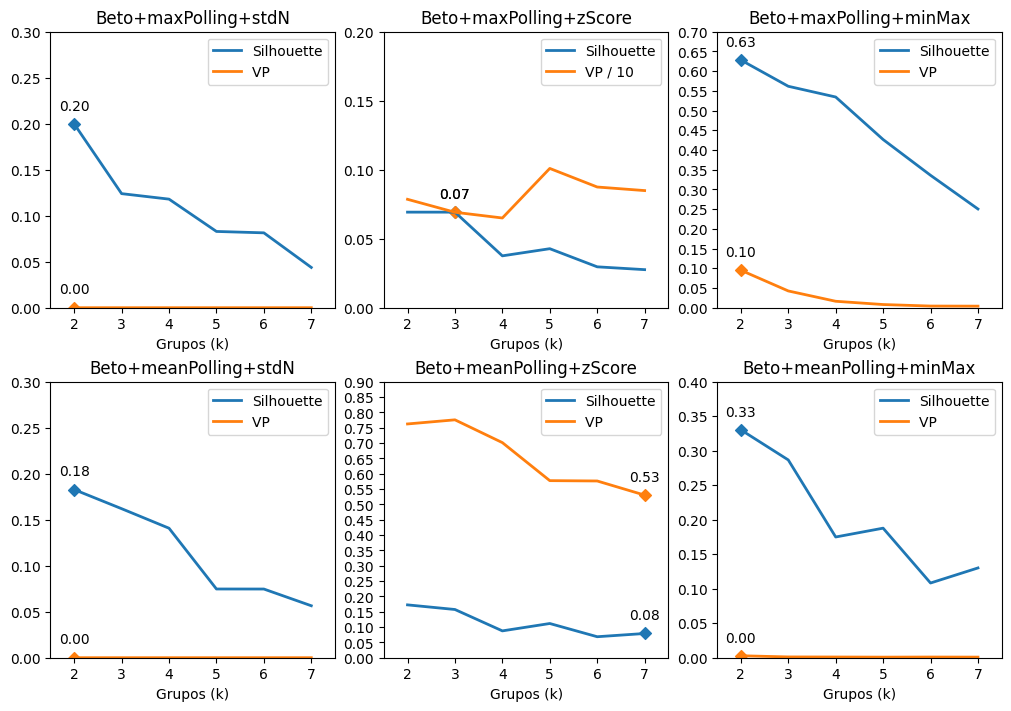

In [11]:
import matplotlib.pyplot as plt
#plt.style.use('_mpl-gallery')
x = range(2, 8)
k_optimos = []
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(10, 7),
                        layout="constrained")
for ax, metricas_key in zip(axs.flat, metricas.keys()):
    sI = metricas[metricas_key]["silhouettes_by_k_centroids"]
    vP, p = Features.decimal_scaling_normalization(np.array(metricas[metricas_key]["VP_by_k_centroids"]))
    p = f"/ {p}" if p >= 10 else ""
    optimo = Features.optimo_k(sI, vP)
    k_optimos.append(optimo)
    print(f"optimo: {optimo} , x(optimo): {x[optimo]}, y(optimo): {sI[optimo]}")
    # plot

    ax.plot(x, sI, linewidth=2.0, label="Silhouette")
    ax.plot(x, vP, linewidth=2.0, label=f"VP {p}")
    ax.scatter([x[optimo]], [sI[optimo]], marker="D")
    ax.scatter(x[optimo], vP[optimo], marker="D")
    y_max_lim = max([max(vP), max(sI)])
    y_max_lim = round(y_max_lim, 1) + 0.1
    y_max_lim = 1.0 if y_max_lim >= 1.0 else y_max_lim
    y_min_lim = min([min(vP), min(sI)])
    y_min_lim = round(y_min_lim, 1) - 0.05 if y_min_lim < 0.0 else 0.0
    ax.set(xlim=(x[0] - 0.5, x[-1] + 0.5), xticks=np.arange(x[0], x[-1] + 1),
        ylim=(y_min_lim, y_max_lim), yticks=np.arange(y_min_lim, y_max_lim + 0.05, 0.05))
    ax.set_xlabel("Grupos (k)")

    label0 = "{:.2f}".format(sI[optimo])
    ax.annotate(label0,
                (x[optimo],sI[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    label1 = "{:.2f}".format(vP[optimo])
    ax.annotate(label1,
                (x[optimo],vP[optimo]),
                textcoords="offset points",
                xytext=(0,10),
                ha='center')
    ax.set_title(f"{metricas_key}")
    ax.legend()
k_optimos = np.array(k_optimos) + 2

plt.show()

# visualización de resultados de analisis de sentimiento en los grupos creados

In [12]:
k_optimos

array([2, 3, 2, 2, 7, 2])

In [13]:
traduccion = {
    "sadness": "tristeza",
    "joy": "alegría",
    "anger": "enojo",
    "surprise": "sorpresa",
    "disgust": "rechazo",
    "Fear": "miedo",
    "others": "otros"
}

In [14]:
i=0
for key, value in data_ml.items():
    kmeans = KMeans(
        n_clusters=k_optimos[i],
        init="random",
        max_iter=10000,
        random_state=42,
        n_init=42,
    ).fit(value)
    agrupamiento[key] = [list(kmeans.labels_), k_optimos[i]]
    i += 1

clusters = {}
for key, value in agrupamiento.items():
    clusters[key] = {}
    for k in range(value[1]):
        clusters[key][f"grupo {k + 1}"] = df_ml.iloc[find_indexs(agrupamiento[key][0], k)]

# preprocesado vs sentimiento.
sentiment_analysis = {}
i=0
for kesI, value0 in clusters.items():
    sentiment_analysis[kesI] = {}
    for kevP, value1 in value0.items():
        sentiment = dict(value1["sentiment"].value_counts())
        sentiment_values = list(sentiment.values())
        sentiment_labels = list(sentiment.keys())
        sentiment_analysis[kesI][kevP] = {f"{traduccion[label]}": value for label, value in zip(sentiment_labels, sentiment_values)}

sentiment_analysis


{'Beto+maxPolling+stdN': {'grupo 1': {'otros': 6, 'enojo': 5, 'tristeza': 1},
  'grupo 2': {'otros': 32, 'enojo': 9, 'tristeza': 5}},
 'Beto+maxPolling+zScore': {'grupo 1': {'otros': 6, 'enojo': 3, 'tristeza': 1},
  'grupo 2': {'enojo': 4, 'otros': 3},
  'grupo 3': {'otros': 29, 'enojo': 7, 'tristeza': 5}},
 'Beto+maxPolling+minMax': {'grupo 1': {'otros': 19,
   'enojo': 7,
   'tristeza': 3},
  'grupo 2': {'otros': 19, 'enojo': 7, 'tristeza': 3}},
 'Beto+meanPolling+stdN': {'grupo 1': {'otros': 26, 'enojo': 7, 'tristeza': 4},
  'grupo 2': {'otros': 12, 'enojo': 7, 'tristeza': 2}},
 'Beto+meanPolling+zScore': {'grupo 1': {'tristeza': 1},
  'grupo 2': {'otros': 14, 'enojo': 4, 'tristeza': 1},
  'grupo 3': {'otros': 9, 'tristeza': 3, 'enojo': 3},
  'grupo 4': {'otros': 8, 'enojo': 2},
  'grupo 5': {'otros': 2, 'tristeza': 1, 'enojo': 1},
  'grupo 6': {'enojo': 3, 'otros': 2},
  'grupo 7': {'otros': 3, 'enojo': 1}},
 'Beto+meanPolling+minMax': {'grupo 1': {'otros': 20,
   'enojo': 8,
   't

In [20]:
lst = [[1,2,3], [3,3]]
def colours(lst):
    print(lst)
    outer = []
    inner = []
    outer_colours = [0, 2, 4, 8, 10, 12, 14]
    inner_colours = range(28)
    i0 = 0
    i1 = 0
    for l in lst:
        outer.append(outer_colours[i0])
        for _ in l:
            inner.append(inner_colours[i1])
            i1 += 1
        i0 += 1
        i1 = i0 * 4
    return outer, inner
colours(lst)

[[1, 2, 3], [3, 3]]


([0, 2], [0, 1, 2, 4, 5])

In [16]:
def list_flatten(lst):
    outputs = []
    for l in lst:
        for e in l:
            outputs.append(e)
    return outputs

[[6, 5, 1], [32, 9, 5]]
[[6, 3, 1], [4, 3], [29, 7, 5]]
[[19, 7, 3], [19, 7, 3]]
[[26, 7, 4], [12, 7, 2]]
[[1], [14, 4, 1], [9, 3, 3], [8, 2], [2, 1, 1], [3, 2], [3, 1]]
[[20, 8, 3], [18, 6, 3]]


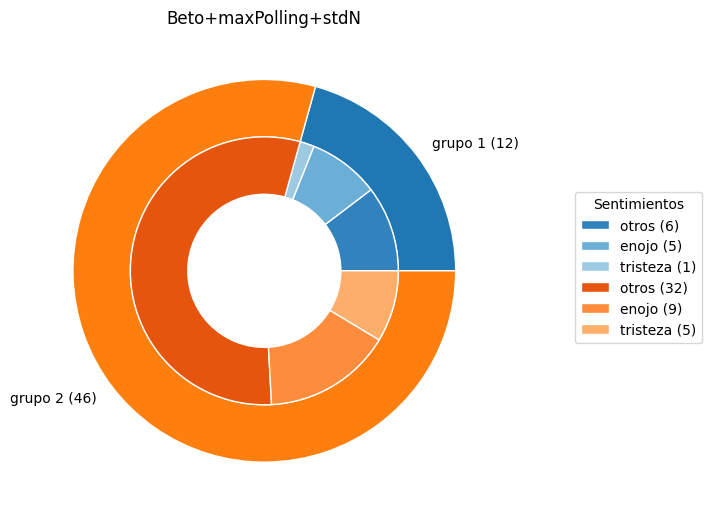

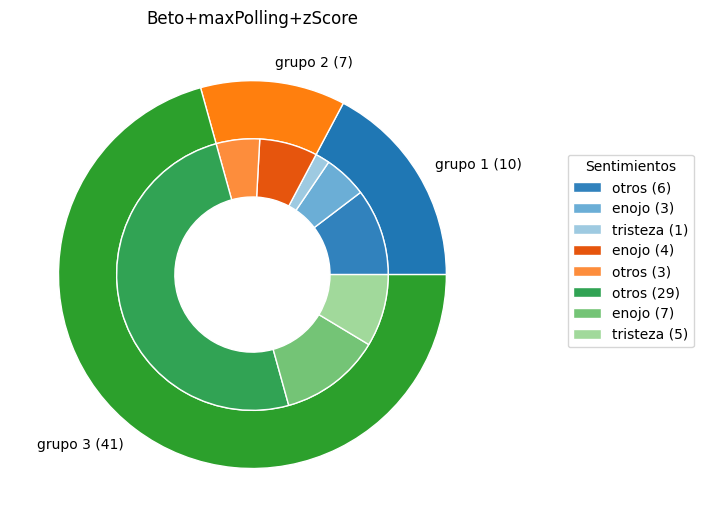

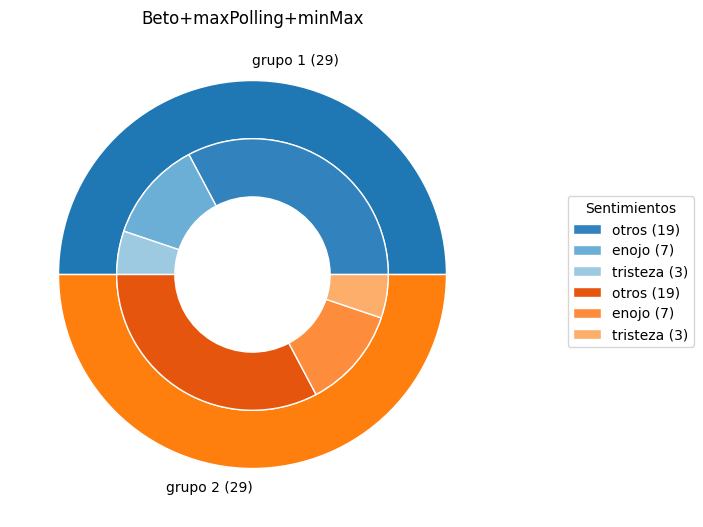

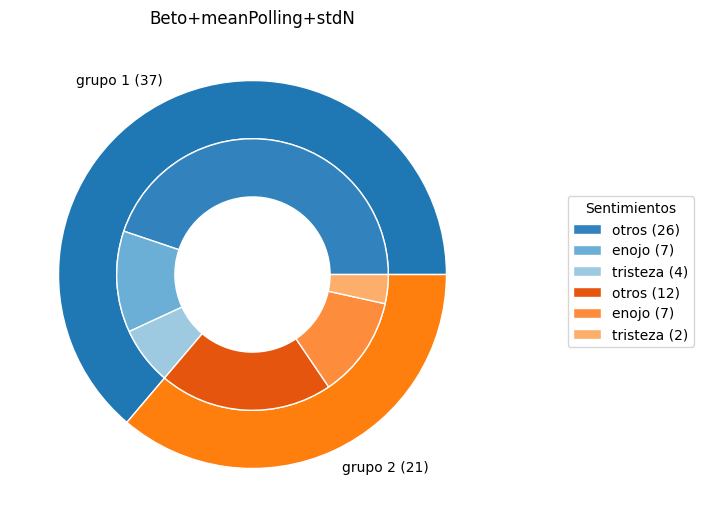

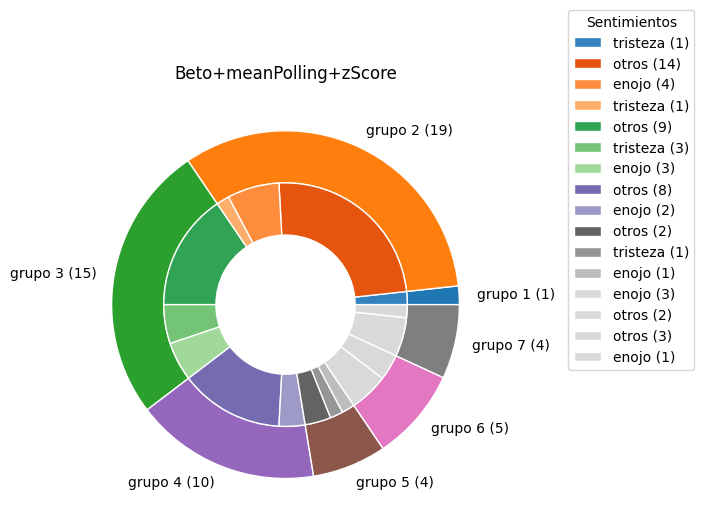

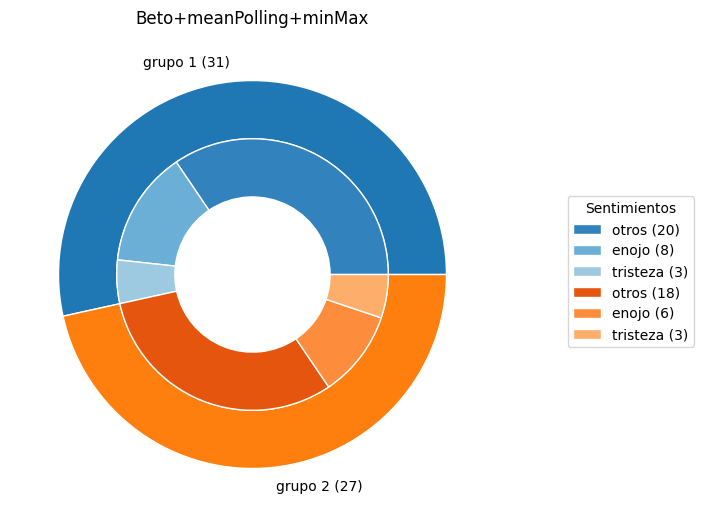

In [21]:
for key in sentiment_analysis.keys():
       fig, ax = plt.subplots(figsize=(7, 6),
                        layout="constrained")
       size = 0.3
       clusters_names = sentiment_analysis[key].keys()
       clusters_sentiments = [list(sentiment_analysis[key][c].keys()) for c in clusters_names]
       clusters_sentiments = list_flatten(clusters_sentiments)
       vals = [list(sentiment_analysis[key][c].values()) for c in clusters_names]
       clusters_names = [f"{c} ({sum(v)})" for c, v in zip(clusters_names, vals)]
       clusters_sentiments = [f"{s} ({v})" for s, v in zip(clusters_sentiments, list_flatten(vals))]

       outer_cmap = plt.get_cmap("tab20")
       inner_cmap = plt.get_cmap("tab20c")
       outer_colors, inner_colors = colours(vals)
       outer_colors = outer_cmap(np.array(outer_colors))
       inner_colors = inner_cmap(np.array(inner_colors))

       sum_vals = [sum(list(i)) for i in vals]
       ax.pie(sum_vals, radius=1, colors=outer_colors, labels=clusters_names,
              wedgeprops=dict(width=size, edgecolor='w'))

       ax.pie(list_flatten(vals), radius=1-size, colors=inner_colors, labels=[" " for _ in clusters_sentiments],
              labeldistance=0.5, wedgeprops=dict(width=size, edgecolor='w'))

       ax.set(aspect="equal", title=f'{key}')
       handles, labels = ax.get_legend_handles_labels()

       ax.legend(handles[len(clusters_names):], clusters_sentiments, loc=(1.15, 0.35), title="Sentimientos")

plt.show()

# Extracción de información

In [22]:
# Example usage
corpus = {}
key_list = list(clusters.keys())
for k in key_list:
    corpus[k] = {}
    for key, value0 in clusters[k].items():
        corpus[k][key] = value0['tweet_text'].tolist()
        # corpus.append(value0['tweet_text'].tolist())
#corpus

In [23]:
from src import Summarize
from sklearn.feature_extraction.text import CountVectorizer
sumarize = Summarize()
vectorizer = CountVectorizer()
# todolos lo procesados
# for k in key_list:
#     tcre_results[k] = {}
#     corpus0 = []
#     cluster_result = []
#     grupo = 0
#     for key, value in corpus[k].items():
#         corpus0 += value
#         cluster_result += [grupo]*len(value)
#         grupo += 1 
#     tcre = sumarize.TCRE(corpus0, cluster_result, vectorizer)
#     for indx, v in enumerate(tcre):
#         tcre_results[k][f"grupo {indx + 1}"] = v[:int(len(v)*0.5)]

# el mejor procesado.
tcre_results = {}
corpus0 = []
cluster_result = []
grupo = 0
for key, value in corpus[op_grouping].items():
    corpus0 += value
    cluster_result += [grupo]*len(value)
    grupo += 1 
tcre = sumarize.TCRE(corpus0, cluster_result, vectorizer)
for indx, v in enumerate(tcre):
    tcre_results[f"grupo {indx + 1}"] = v[:int(len(v)*0.3)]
tcre_results

{'grupo 1': ['uds',
  'adulto',
  'remedio',
  'solucionando',
  'del',
  'true',
  'opciones',
  'automatico',
  'mucho',
  'pick',
  'peor',
  'ayuda',
  'solo',
  'call',
  'recuperarla',
  'hoy',
  'estaba',
  'que',
  'mis',
  'sistema',
  'mi',
  'realmente',
  'anular',
  'compra',
  '23',
  'tema',
  'siguiente',
  'pedido',
  'el'],
 'grupo 2': ['un',
  'cambian',
  'recibi',
  'acceso',
  'hacer',
  'respecto',
  'etiqueta',
  'estafa',
  'como',
  'este',
  'bloqueada',
  'pude',
  'compras',
  'tramo',
  'preparacion',
  'yo',
  'viendo',
  'comprar',
  'verificando',
  'cuenta',
  'tanto',
  'diciembre',
  'problema',
  'aplicacion',
  'ci',
  'llegan',
  'hay',
  'envia',
  'da']}

In [24]:
# from nltk.tokenize import sent_tokenize

# sentences = sent_tokenize(text2)
vectorizer = CountVectorizer()
# A = vectorizer.fit_transform(sentences).toarray()
# A = A.T
# A.shape
lsa_results = {}

for key, value in corpus[op_grouping].items():
    A = vectorizer.fit_transform(value).toarray()
    A = A.T
    score_indices = Summarize.LSA_summary(A, 3)
    lsa_results[key] = [value[idx] for idx in score_indices]

lsa_results

{'grupo 1': ['tengo el mismo problema, todos los botones me devuelven a"contactar al vendedor" y el no responde, necesito el dinero devuelta para comprar el regalo en otra parte',
  'nunca mas compro con este oferente de servicios se pasaron que falta de profesionalismo de mercado libre al no saber el comportamiento de sus socios',
  'de que sirve tener cuenta protegida, si no sirve cuando se quiere cancelar una compra. mensaje dice contacte al vendedor. son parte de una estafa entonces.'],
 'grupo 2': ['hola buenos dias. tengo un problema con el inicio de sesion de mi cuenta de mercado libre. esta cuenta no la abro hace mucho tiempo y ahora quiero abrirla. cuando me pide fotos de mi rostro y de mi carnet va todo bien. pero luego me envian la respuesta que no soy la persona que..',
  'desde ayer que no tengo claridad de lo que pasa con mi pedido y devolucion del dinero. ayer fue imposible anular una de las compras me decia que lo clave habia caducado. cuando realice la compra por prime